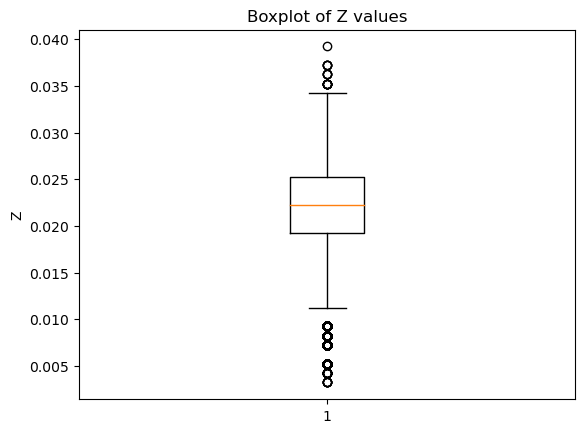

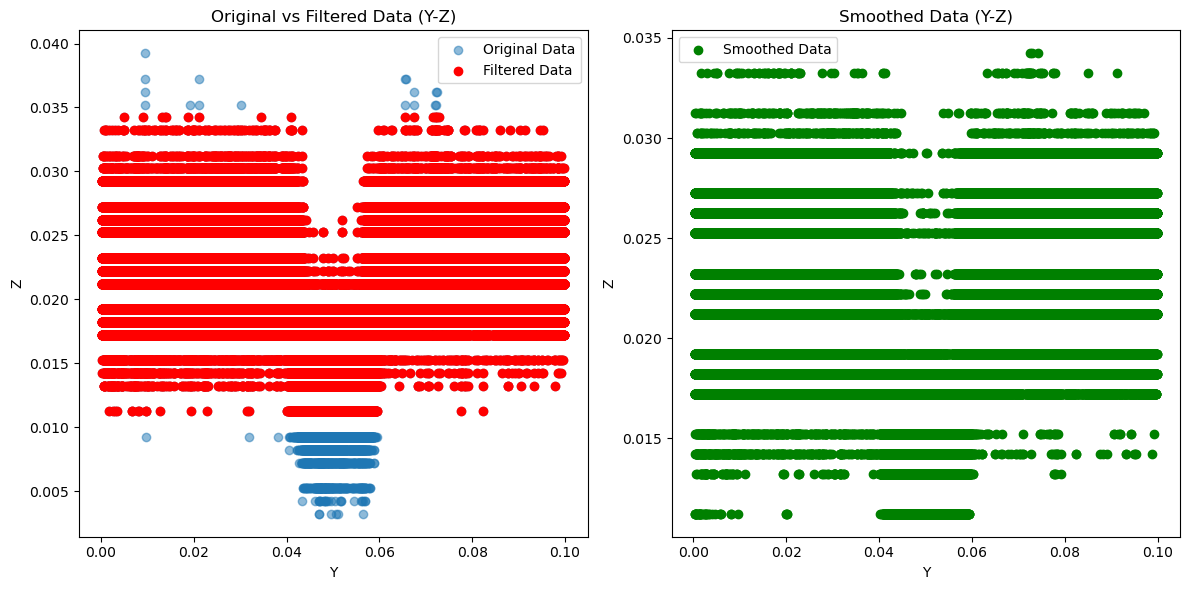

(0.05, 0.02311182905779286)


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define the path to your .txt file
file_path = 'C:/Users/rjhyu/파이썬 연습/23.12.09 오류 원인 찾기/C15mm00deg.txt'

# Read the file and extract the x, y, z values
data = []
with open(file_path, 'r') as file:
    for line in file:
        values = line.strip().split()  # Split the line into individual values
        if len(values) >= 3:
            try:
                x, y, z = float(values[0]), float(values[1]), float(values[2])  # Extract x, y, z
                data.append([x, y, z])
            except ValueError:
                # Skip lines that cannot be converted to floats
                continue

# Create a DataFrame from the extracted data
df = pd.DataFrame(data, columns=['x', 'y', 'z'])

# 시각화: z 값에 대한 박스 플롯
plt.boxplot(df['z'])
plt.title('Boxplot of Z values')
plt.ylabel('Z')
plt.show()

# 이상치 탐지 및 제거: IQR 방법 사용
Q1 = df['z'].quantile(0.25)
Q3 = df['z'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치를 필터링하고 결과를 새 DataFrame에 저장
df_filtered = df[(df['z'] >= lower_bound) & (df['z'] <= upper_bound)].copy()

# 데이터 스무딩: 이동 평균 사용 (예: 5개 데이터 포인트에 대한 이동 평균)
window_size = 5
smoothed_values = df_filtered['z'].rolling(window=window_size).median()
df_filtered.loc[:, 'z_smoothed'] = smoothed_values


# 필터링 및 스무딩된 데이터 시각화: y-z 산점도
plt.figure(figsize=(12, 6))

# 원본 데이터와 필터링된 데이터 비교
plt.subplot(1, 2, 1)
plt.scatter(df['y'], df['z'], alpha=0.5, label='Original Data')
plt.scatter(df_filtered['y'], df_filtered['z'], color='red', label='Filtered Data')
plt.title('Original vs Filtered Data (Y-Z)')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend()

# 스무딩된 데이터
plt.subplot(1, 2, 2)
plt.scatter(df_filtered['y'], df_filtered['z_smoothed'], color='green', label='Smoothed Data')
plt.title('Smoothed Data (Y-Z)')
plt.xlabel('Y')
plt.ylabel('Z')
plt.legend()

plt.tight_layout()
plt.show()


# 원래 분석 과정을 스무딩된 데이터에 대해 계속 진행
# Calculate the median x value and define the range for analysis (10cm up and down from the median)
median_x = df_filtered['x'].median()
range_start = median_x - 0.1
range_end = median_x + 0.1

# First filter the DataFrame for the x value range around the median
filtered_df_x = df_filtered[(df_filtered['x'] >= range_start) & (df_filtered['x'] <= range_end)]

# Within this filtered data, further filter based on the specified y value ranges
filtered_df = filtered_df_x[((filtered_df_x['y'] >= 0) & (filtered_df_x['y'] <= 0.03)) | ((filtered_df_x['y'] >= 0.07) & (filtered_df_x['y'] <= 0.1))]

# Calculate the average z value from the doubly filtered DataFrame
average_z_value = filtered_df['z_smoothed'].mean()

# Define the reference point using the calculated average z value
reference_point = (0.05, average_z_value)
print(reference_point)

# Find the minimum and maximum x values to divide the sections accurately
min_x = df_filtered['x'].min()
max_x = df_filtered['x'].max()
section_width = (max_x - min_x) / 20

# Initialize the results DataFrame
results_df = pd.DataFrame(columns=['Section', 'Y Distance (mm)', 'Left Point Y', 'Left Point Z', 'Right Point Y', 'Right Point Z'])

# Process the sections
for i in range(20):
    section_min_x = min_x + (i * section_width)
    section_max_x = min_x + ((i + 1) * section_width)
    section_label = f"{section_min_x:.2f} to {section_max_x:.2f}"
    
    # Filter rows based on the x value section and z value margin
    filtered_df = df_filtered[(df_filtered['x'] >= section_min_x) & (df_filtered['x'] < section_max_x) & (abs(df_filtered['z_smoothed'] - reference_point[1]) <= 0.001)]
    
    # Sort filtered_df based on the y value
    filtered_df = filtered_df.sort_values(by='y')
    
    # Find the closest point to the left of y=0.05
    left_point = filtered_df[filtered_df['y'] < reference_point[0]].iloc[-1] if not filtered_df[filtered_df['y'] < reference_point[0]].empty else None
    
    # Find the closest point to the right of y=0.05
    right_point = filtered_df[filtered_df['y'] > reference_point[0]].iloc[0] if not filtered_df[filtered_df['y'] > reference_point[0]].empty else None
    
    # Calculate the y distance between the two points and append the result to results_df
    if left_point is not None and right_point is not None:
        distance_y = abs(right_point['y'] - left_point['y']) * 1000  # Convert to mm
        new_row = pd.DataFrame({
            'Section': [section_label],
            'Y Distance (mm)': [distance_y],
            'Left Point Y': [left_point['y']],
            'Left Point Z': [left_point['z']],
            'Right Point Y': [right_point['y']],
            'Right Point Z': [right_point['z']]
        })
        results_df = pd.concat([results_df, new_row], ignore_index=True)

# Save results_df to a new Excel file
results_df.to_excel('C:/Users/rjhyu/파이썬 연습/23.12.09 오류 원인 찾기/results.xlsx', index=False)

